<img src="images/Picture0.png" width=200x />

# Notebook 04b - Logistic Regression - Supplement

## Instructions
...

## Pre-requisites
...

## Credits
...


## If you are using Colab, save a copy of this notebook!!

Before we get started, it is crucially important that you **save a copy of the notebook** to a local folder if you are accessing this notebook in Google Colab! Please go to:

```
File -> Make a copy
```


In [ ]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
# Read in Data
uci_adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
     sep = ",",
     header = None,
     na_values = ['NA','?']
  )

# Add all column names
uci_adult_df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

display(uci_adult_df)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Splitting Data

The standard practice when modeling is to split a single data set into two:

- **Training**: Data that should be used to train the model.
- **Testing**: Data that should be used to evaluate the predictions made by the trained model.

Usually, the percentage is about an 80/20% split with 80% going to training and 20% going to testing.

In [ ]:
# Load train_test_split function in the model_selection module for sklearn
from sklearn.model_selection import train_test_split

# Split the data with 20% in testing and 80% in training.
train, test = train_test_split(uci_adult_df, test_size=0.2)


train.info()
test.info()

,<=50K,>50K
14596,0,1
30066,0,1
2417,1,0
14540,1,0
14743,1,0
...,...,...
19390,1,0
25490,1,0
5863,1,0
3232,1,0


In [ ]:
## logistic regression expects 0s and 1s as the response variable
tempVec = pd.get_dummies(train['Income'])
tempVec

train['Income_Binary'] = tempVec[' >50K']

tempVec = pd.get_dummies(test['Income'])

test['Income_Binary']  = tempVec[' >50K']

Let's fit a model on the training data and see how well it does on the testing data.

In [ ]:

# Specify the desired model of y regressing onto x
model_formula = smf.logit('Income_Binary ~ Age + Race + Gender + HoursPerWeek', data = train)

# Fit the model to the data
results = model_formula.fit()

results.params

Optimization terminated successfully.
         Current function value: 0.478521
         Iterations 7


Intercept                     -6.091197
Race[T. Asian-Pac-Islander]    0.951035
Race[T. Black]                 0.205467
Race[T. Other]                -0.374179
Race[T. White]                 0.834159
Gender[T. Male]                1.019539
Age                            0.041588
HoursPerWeek                   0.040522
dtype: float64

In [ ]:
## Test accuracy
pred = results.predict(test)
predV = results.predict(test)
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0
test_acc = (test['Income_Binary'] == pred).mean()
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(test_acc))

Accuracy of logistic regression classifier on test set: 0.75


Let's break that down to decide in what ways we are wrong and right.

In [ ]:
from sklearn.metrics import confusion_matrix       ## logistic regression report packages
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Confusion matrix
confusion_matrix = confusion_matrix(test['Income_Binary'], pred)
print(confusion_matrix)

[[4687  215]
 [1393  218]]


The top left value means that the true value is 1 and we correctly predicted a 1 (true positive). The top right value means that the true value is 1 and we incorrectly predicted a 0 (false negative). The bottom left value means that the true value is 0 and we incorrectly predicted a 1 (false positive). The bottom right value means that the true value is 0 and we correctly predicted a 0 (true negative).

All of this has assumed that 0.5 is the appropriate cutoff value to turn predicted probabilities into binary predictions. What if we change this cutoff value? The ROC curve shows how well the model does under different cutoff values. Informally, we want the area under the curve to be large, so we want the curve to be as close to the upper left corner as possible. Read more about how to interpret this type of curve [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).



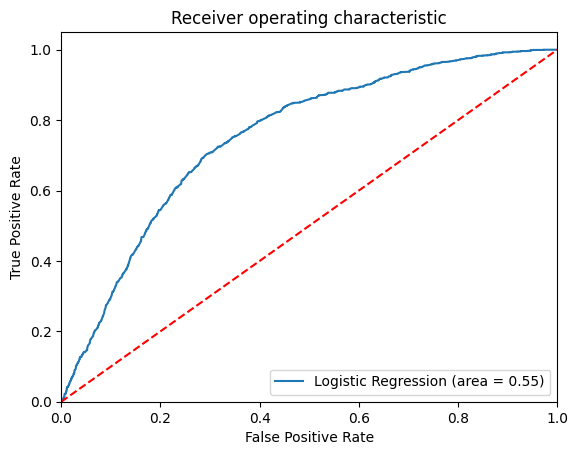

In [ ]:
# ROC curve
logit_roc_auc = roc_auc_score(test['Income_Binary'], pred)
fpr, tpr, thresholds = roc_curve(test['Income_Binary'], predV)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Your Turn

Fit your own logistic regression model choosing a different binary response. Remember you will need to convert the categorical variable into a 0/1 variable before proceeding. Be sure to evaluate the fit of the model using a test dataset that the model has *not* been trained. on.